In [1]:
import json
import os
import numpy as np
import torch
import gdown

# Function to convert a grid to tensor format
def grid_to_tensor(grid):
    # Convert the grid to a numpy array and then to a torch tensor
    grid_np = np.array(grid, dtype=np.int64)  # Ensure data type is consistent for later use in CNN
    grid_tensor = torch.tensor(grid_np, dtype=torch.long)  # Use long if classes are integer-based (0-9)
    return grid_tensor

# Function to process JSON data and store as dictionary of lists grouped by task_id
def process_json_data_to_dict(challenges_data, solutions_data, output_dir):
    data_dict = {}  # Dictionary to store data grouped by task_id
    
    for task_id, task_data in challenges_data.items():
        data_dict[task_id] = []  # Initialize a list for each task_id

        # Process each training example
        for example in task_data.get("train", []):
            input_tensor = grid_to_tensor(example["input"])
            output_tensor = grid_to_tensor(example["output"])
            data_dict[task_id].append((input_tensor, output_tensor))  # Append (input, output) pair

        # Process each test example and retrieve output from the solutions file
        test_solutions = solutions_data.get(task_id, [])  # Retrieve solutions using task_id
        for i, example in enumerate(task_data.get("test", [])):
            input_tensor = grid_to_tensor(example["input"])

            if i < len(test_solutions):  # Check if solution exists for this test example
                output_tensor = grid_to_tensor(test_solutions[i])  # Use the solution output
            else:
                output_tensor = None  # If no solution is available, set to None

            data_dict[task_id].append((input_tensor, output_tensor))  # Append (input, output) pair
    
    # Save the data dictionary as a .pt file
    save_path = os.path.join(output_dir, "grouped_data_by_task.pt")
    torch.save(data_dict, save_path)
    print(f"Data saved to {save_path} grouped by task_id.")

# Download JSON files
url_challenges = "https://drive.google.com/uc?id=1humrcrnvRKvmfnd-GKxNA76oUvdQ7JO-"
url_solutions = "https://drive.google.com/uc?id=1GAHQwLAaPRMq9tqHwlU1WBeeJmNJ4grx"

url_eval_challenges = "https://drive.google.com/uc?export=download&id=1E8fjyXyOyd_MG5UgjgyybvR1mKpLeiF4"
url_eval_solutions = "https://drive.google.com/uc?export=download&id=1Cdx0w80IfN9r5YPwGje2KDkV1XCR46w-"


challenges_file = "challenges_data.json"
solutions_file = "solutions_data.json"

eval_challenges_file = "eval_challenges_data.json"
eval_solutions_file = "eval_solutions_data.json"
gdown.download(url_challenges, challenges_file, quiet=False)
gdown.download(url_solutions, solutions_file, quiet=False)

gdown.download(url_eval_challenges, eval_challenges_file, quiet=False)
gdown.download(url_eval_solutions, eval_solutions_file, quiet=False)

# Load JSON data
with open(challenges_file, "r") as file:
    challenges_data = json.load(file)
with open(solutions_file, "r") as file:
    solutions_data = json.load(file)
    
with open(eval_challenges_file, "r") as file:
    eval_challenges_data = json.load(file)
with open(eval_solutions_file, "r") as file:
    eval_solutions_data = json.load(file)


# Specify the output directory and process data
output_directory = "cnn_dataset"
os.makedirs(output_directory, exist_ok=True)

eval_output_directory = "eval_cnn_dataset"
os.makedirs(eval_output_directory, exist_ok=True)

# Process JSON data and save as a dictionary of lists of tensors grouped by task_id
process_json_data_to_dict(challenges_data, solutions_data, output_directory)
process_json_data_to_dict(eval_challenges_data, eval_solutions_data, eval_output_directory)

Downloading...
From: https://drive.google.com/uc?id=1humrcrnvRKvmfnd-GKxNA76oUvdQ7JO-
To: /Users/mohamadaltrabulsi/Downloads/challenges_data.json
100%|██████████| 1.27M/1.27M [00:00<00:00, 16.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GAHQwLAaPRMq9tqHwlU1WBeeJmNJ4grx
To: /Users/mohamadaltrabulsi/Downloads/solutions_data.json
100%|██████████| 185k/185k [00:00<00:00, 908kB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1E8fjyXyOyd_MG5UgjgyybvR1mKpLeiF4
To: /Users/mohamadaltrabulsi/Downloads/eval_challenges_data.json
100%|██████████| 2.06M/2.06M [00:00<00:00, 16.0MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1Cdx0w80IfN9r5YPwGje2KDkV1XCR46w-
To: /Users/mohamadaltrabulsi/Downloads/eval_solutions_data.json
100%|██████████| 313k/313k [00:00<00:00, 10.3MB/s]


Data saved to cnn_dataset/grouped_data_by_task.pt grouped by task_id.
Data saved to eval_cnn_dataset/grouped_data_by_task.pt grouped by task_id.


/var/folders/xh/2rdxqvg92lg7xvg6y302f5pr0000gn/T/ipykernel_76200/4052056440.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


Task 0 has 4 inputs and 4 outputs.


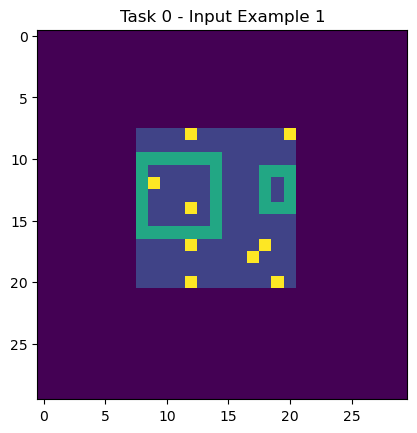

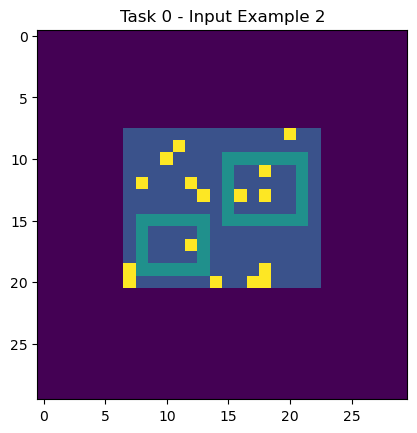

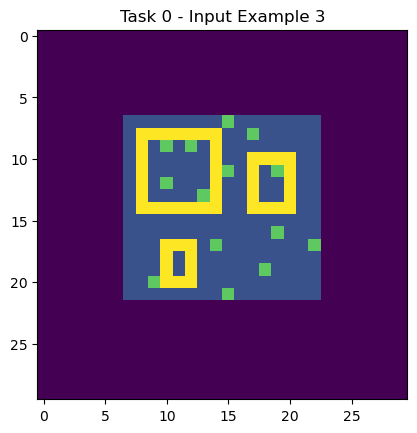

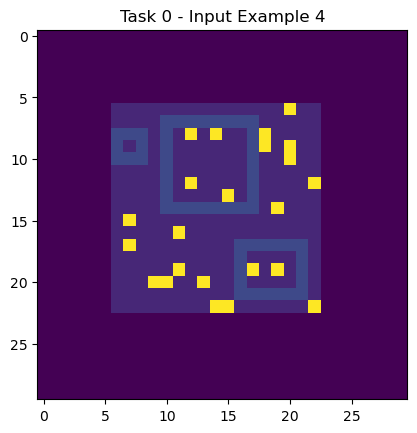

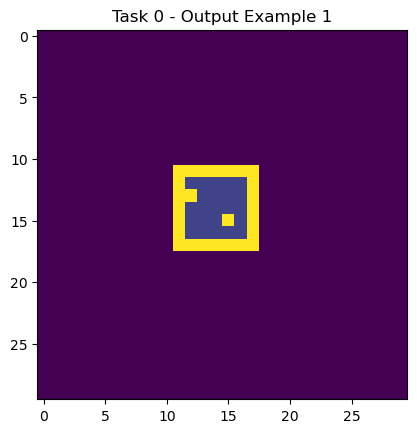

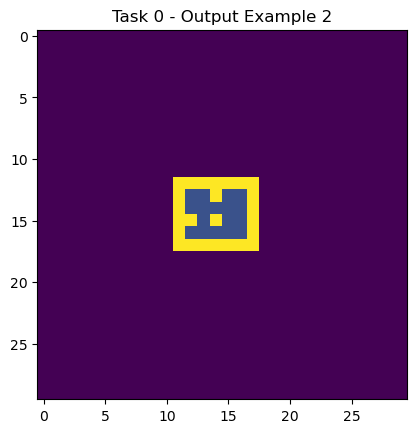

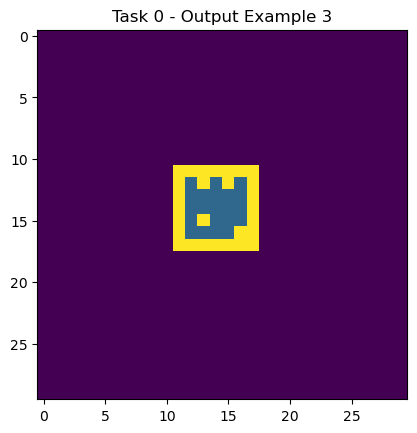

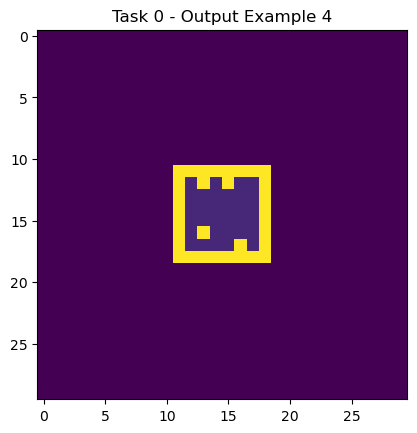

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GridDataset(Dataset):
    def __init__(self, data_path, target_size=(30, 30), frame_value=0):
        # Load the saved data
        data = torch.load(data_path)
        self.tasks = list(data.values())  # Each task is a list of examples (all tasks)
        self.target_size = target_size
        self.frame_value = frame_value

    def __len__(self):
        return len(self.tasks)

    def pad_to_target_size(self, tensor):
        height, width = tensor.shape
        pad_top = (self.target_size[0] - height) // 2
        pad_bottom = self.target_size[0] - height - pad_top
        pad_left = (self.target_size[1] - width) // 2
        pad_right = self.target_size[1] - width - pad_left

        # Apply padding with the specified frame value
        padded_tensor = F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=self.frame_value)
        return padded_tensor

    def __getitem__(self, idx):
        task_data = self.tasks[idx]
        inputs = []
        outputs = []

        for input_grid, output_grid in task_data:
            # Process input grid
            input_tensor = input_grid + 1  # Adjust if necessary
            input_padded = self.pad_to_target_size(input_tensor)
            inputs.append(input_padded)

            # Process output grid if it exists
            if output_grid is not None:
                output_tensor = output_grid + 1  # Adjust if necessary
                output_padded = self.pad_to_target_size(output_tensor)
                outputs.append(output_padded)
            else:
                outputs.append(None)

        # If all outputs are None, return an empty tensor for consistency
        return torch.stack(inputs), torch.stack([o for o in outputs if o is not None]) if outputs else torch.empty(0)

def custom_collate(batch):
    # batch is a list of tuples (inputs, outputs)
    inputs, outputs = zip(*batch)
    return inputs, outputs

# Usage example
data_path = "cnn_dataset/grouped_data_by_task.pt"
dataset = GridDataset(data_path)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)

eval_data_path = "cnn_dataset/grouped_data_by_task.pt"
eval_dataset = GridDataset(data_path)
eval_data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)

# Example of how to visualize data from the modified DataLoader
for batch_idx, (inputs, outputs) in enumerate(eval_data_loader):
    task_inputs = inputs[0]
    task_outputs = outputs[0] if outputs[0] is not None and len(outputs[0]) > 0 else None
    print(f"Task {batch_idx} has {len(task_inputs)} inputs and {len(task_outputs) if task_outputs is not None else 0} outputs.")

    # Visualize inputs
    for i in range(task_inputs.size(0)):
        plt.imshow(task_inputs[i].numpy(), cmap="viridis")
        plt.title(f"Task {batch_idx} - Input Example {i+1}")
        plt.show()

    # Visualize outputs if they exist
    if task_outputs is not None:
        for i in range(task_outputs.size(0)):
            plt.imshow(task_outputs[i].numpy(), cmap="viridis")
            plt.title(f"Task {batch_idx} - Output Example {i+1}")
            plt.show()
    break  # Remove to iterate through all tasks


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# training hyperparameters
train_epochs = 1
# loop over each task x times before testing
train_task_loops = 1

train_lr = 0.001
eval_lr = 0.001

eval_epochs = 1
# loop over each task x times before testing
eval_task_loops = 10

In [12]:
import torch
import torch.nn as nn
from tqdm import tqdm

class TheThinker(nn.Module):
  def __init__(self):
    super(TheThinker, self).__init__()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=6, padding=1)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=6, padding=1)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=6, padding=1)
    self.bn1 = nn.BatchNorm2d(8)
    self.bn2 = nn.BatchNorm2d(16)
    self.bn3 = nn.BatchNorm2d(32)

    self.flatten = nn.Flatten()
    # current shape (2916)
    self.fc1 = nn.LazyLinear(1000)
    self.fc2 = nn.LazyLinear(9900)

    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
      
    self.all_train_loss = []
    self.all_train_accuracy = []

    self.test_train_loss = []
    self.test_train_accuracy = []
      
    self.all_eval_loss = []
    self.all_eval_accuracy = []

    self.test_eval_loss = []
    self.test_eval_accuracy = []

    self.to_freeze = [self.conv1, self.conv2, self.conv3, self.bn1, self.bn2, self.bn3]

  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.flatten(x)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  def visualize_predic(self, x_example, predict, y_example):
    predicted_classes = torch.argmax(predict, dim=1) 
    x_example = x_example.squeeze() 
    predict = predicted_classes[0].view(30, 30) 
    target = y_example.view(30, 30) 
    # Ensure images are in 30x30 format
    input_image = x_example.squeeze()  
    predicted_image = predict.squeeze()  
    target_image = target.squeeze()

    # Plot the images side by side
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    
    # Input Image
    axes[0].imshow(input_image.cpu())
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Predicted Output
    axes[1].imshow(predicted_image.cpu())
    axes[1].set_title("Predicted Output")
    axes[1].axis("off")

    # Target (Actual) Output
    axes[2].imshow(target_image.cpu(), cmap='gray')
    axes[2].set_title("Target Output")
    axes[2].axis("off")
    plt.show()

  def freeze_layers(self):
    for layer in self.to_freeze:
      for param in layer.parameters():
        param.requires_grad = False

  def unfreeze_layers(self):
    for layer in self.to_freeze:
      for param in layer.parameters():
        param.requires_grad = True
      
  def calculate_accuracy(self, prediction, target):
    predicted_classes = torch.argmax(prediction, dim=1) 
    correct_predictions = (predicted_classes == target).sum().item()
    accuracy_percentage = (correct_predictions / target.numel()) * 100 
    return accuracy_percentage

  def train_model(self, train_loader, val = False, repetitions=1, visualize=False):
    self.to(device)  
    if val:
        self.freeze_layers()
        # Set learning rate to eval_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = eval_lr
    else:
        self.unfreeze_layers()
        # Set learning rate to train_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = train_lr
    for batch in tqdm(train_loader):
      x_task, y_task = batch[0][0], batch[1][0] 
      x_test, y_test = x_task[-1], y_task[-1]
      x_task, y_task = x_task[:-1], y_task[:-1]
      for i in range(repetitions):
        for x_example, y_example in zip(x_task, y_task):
          x = x_example.unsqueeze(0).unsqueeze(0).float().to(device) 
          y = y_example.long().to(device).view(1, 900) 
          predict = self(x)
          predict = predict.view(1, 11, 900) 
          
          loss = self.criterion(predict, y)
          acc = self.calculate_accuracy(predict, y)

          if val:
            self.all_eval_loss.append(loss.item())
            self.all_eval_accuracy.append(acc)
          else:
            self.all_train_loss.append(loss.item())
            self.all_train_accuracy.append(acc)
                
          loss.backward()
          self.optimizer.step()
          self.optimizer.zero_grad()

      x_test = x_test.unsqueeze(0).unsqueeze(0).float().to(device) 
      y_test = y_test.long().to(device).view(1, 900) 
      predict = self(x_test)
      predict = predict.view(1, 11, 900) 
      loss = self.criterion(predict, y_test)
      acc = self.calculate_accuracy(predict, y_test)

      if val:
          self.test_eval_loss.append(loss.item())
          self.test_eval_accuracy.append(acc)
          self.all_eval_loss.append(loss.item())
          self.all_eval_accuracy.append(acc)
      else:
          self.test_train_loss.append(loss.item())
          self.test_train_accuracy.append(acc)
          self.all_train_loss.append(loss.item())
          self.all_train_accuracy.append(acc)
          
      if visualize:
        with torch.no_grad():
          self.visualize_predic(x_test, predict, y_test)
            
network = TheThinker().to('cpu')

In [15]:
for i in range(train_epochs):
    network.train_model(data_loader, repetitions=train_task_loops)
network.train_model(eval_data_loader, val=True, repetitions=eval_task_loops)

100%|██████████| 400/400 [15:42<00:00,  2.36s/it]


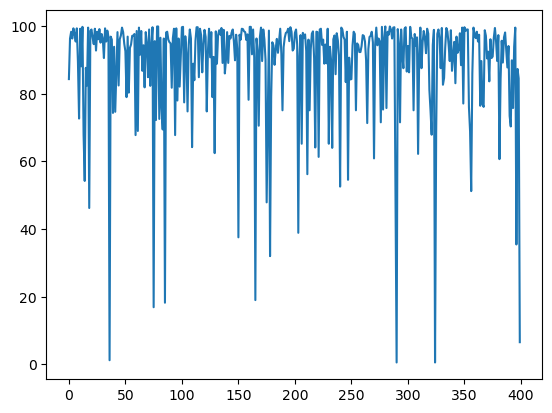

In [16]:
#plt.plot(network.all_train_loss)
#plt.plot(network.all_train_accuracy)
#plt.plot(network.test_eval_loss)
plt.plot(network.test_eval_accuracy)

In [21]:
num_above_95 = sum(1 for acc in network.test_eval_accuracy if acc > 95)
print(f"Number of accuracies above 95%: {num_above_95}")


Number of accuracies above 95%: 203


In [23]:
class InceptionModule(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(InceptionModule, self).__init__()
    # 1x1 Convolution
    self.branch1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

        # 3x3 Convolution
    self.branch2 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

        # 5x5 Convolution
    self.branch3 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=5, padding=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

        # 7x7 Convolution
    self.branch4 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=7, padding=3),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    # Apply each branch and concatenate outputs along the channel dimension
    branch1 = self.branch1(x)
    branch2 = self.branch2(x)
    branch3 = self.branch3(x)
    branch4 = self.branch4(x)
    return torch.cat([branch1, branch2, branch3, branch4], dim=1)

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU()

  def forward(self, x):
    residual = x
    x = self.relu(self.bn1(self.conv1(x)))
    return x + residual  # Residual connection

class CNN2(TheThinker):
  def __init__(self):
    super(TheThinker, self).__init__()
    self.relu = nn.ReLU()

    # Initial Convolution Block
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, padding=3)
    self.bn1 = nn.BatchNorm2d(16)

    # Residual Block + Inception Module + Dropout
    self.residual1 = ResidualBlock(16, 16)
    self.inception1 = InceptionModule(16, 8)  # Total output channels = 8 * 4 = 32
    self.dropout1 = nn.Dropout(p=0.3)

    # Residual Block + Inception Module + Dropout
    self.residual2 = ResidualBlock(32, 32)
    self.inception2 = InceptionModule(32, 16)  # Total output channels = 16 * 4 = 64
    self.dropout2 = nn.Dropout(p=0.3)

    # Residual Block + Inception Module + Dropout
    self.residual3 = ResidualBlock(64, 64)
    self.inception3 = InceptionModule(64, 32)  # Total output channels = 32 * 4 = 128
    self.dropout3 = nn.Dropout(p=0.3)

        # Fully Connected Layers
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(1152, 512)  # Adjusted input features based on output size after convolutions
    self.fc2 = nn.Linear(512, 9900)   # Final output size (adjust as needed)

        # Loss and Optimizer
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    
    self.all_train_loss = []
    self.all_train_accuracy = []
    self.test_train_loss = []
    self.test_train_accuracy = []
    self.all_eval_loss = []
    self.all_eval_accuracy = []
    self.test_eval_loss = []
    self.test_eval_accuracy = []

    self.to_freeze = [self.residual1, self.inception1, self.dropout1, self.residual2, self.inception2, self.dropout2, self.residual3, self.inception3, self.dropout3]


  def forward(self, x):
    # Initial Conv Layer
    x = self.relu(self.bn1(self.conv1(x)))  
    # First Residual Block + Inception Module + Dropout + MaxPooling
    x = self.residual1(x)
    x = self.inception1(x)
    x = self.dropout1(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)  
    # Second Residual Block + Inception Module + Dropout + MaxPooling
    x = self.residual2(x)
    x = self.inception2(x)
    x = self.dropout2(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)  
    # Third Residual Block + Inception Module + Dropout + MaxPooling
    x = self.residual3(x)
    x = self.inception3(x)
    x = self.dropout3(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)  
    # Flatten and Fully Connected Layers
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

network2 = CNN2().to(device)


In [24]:
for i in range(train_epochs):
  network2.train_model(data_loader, repetitions=train_task_loops)
network2.train_model(eval_data_loader, val=True, repetitions=eval_task_loops)


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [05:15<00:00,  1.27it/s]


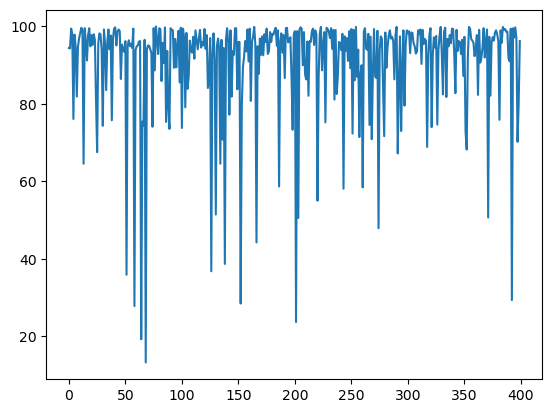

Number of accuracies above 95%: 222


In [25]:
#plt.plot(network.all_train_loss)
#plt.plot(network.all_train_accuracy)
#plt.plot(network2.test_eval_loss)
plt.plot(network2.test_eval_accuracy)
plt.show()
num_above_95 = sum(1 for acc in network2.test_eval_accuracy if acc > 95)
print(f"Number of accuracies above 95%: {num_above_95}")


In [27]:
class ResidualBlockWithDilation(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlockWithDilation, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=2, dilation=2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        return x + residual  # Residual connection
        
class CNN3(TheThinker):
  def __init__(self):
    super(TheThinker, self).__init__()
    self.relu = nn.ReLU()    
    # Initial Convolution Block with Dilation
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=6, padding=2, dilation=2)
    self.bn1 = nn.BatchNorm2d(16)    
    # Residual Block + Conv2d with Dilation + Dropout
    self.residual1 = ResidualBlockWithDilation(16, 16)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=2, dilation=2)
    self.bn2 = nn.BatchNorm2d(32)
    self.dropout1 = nn.Dropout(p=0.3)    
    # Residual Block + Conv2d with Dilation + Dropout
    self.residual2 = ResidualBlockWithDilation(32, 32)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=2, dilation=2)
    self.bn3 = nn.BatchNorm2d(64)
    self.dropout2 = nn.Dropout(p=0.3)   
    # Residual Block + Conv2d with Dilation + Dropout
    self.residual3 = ResidualBlockWithDilation(64, 64)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=2, dilation=2)
    self.bn4 = nn.BatchNorm2d(128)
    self.dropout3 = nn.Dropout(p=0.3)   
    # Residual Block + Conv2d with Dilation + Dropout
    self.residual4 = ResidualBlockWithDilation(128, 128)
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=2, dilation=2)
    self.bn5 = nn.BatchNorm2d(256)
    self.dropout4 = nn.Dropout(p=0.3)   
    # Fully Connected Layers
    self.flatten = nn.Flatten()
    self.fc1 = nn.LazyLinear(512)  # Adjusted input features based on output size after convolutions
    self.fc2 = nn.Linear(512, 9900)   # Final output size (adjust as needed    
    # Loss and Optimizer
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
      
    self.all_train_loss = []
    self.all_train_accuracy = []
    self.test_train_loss = []
    self.test_train_accuracy = []
    self.all_eval_loss = []
    self.all_eval_accuracy = []
    self.test_eval_loss = []
    self.test_eval_accuracy = []

    self.to_freeze = [self.conv1, self.bn1, self.residual1, self.conv2, self.bn2, self.dropout1, self.residual2, self.conv3, self.bn3, self.dropout2, 
                     self.residual3, self.conv4, self.bn4, self.dropout3, self.residual4, self.conv5, self.bn5, self.dropout4]


    def forward(self, x):
      # Initial Dilated Conv Layer
      x = self.relu(self.bn1(self.conv1(x)))  
      # First Residual Block + Conv2d with Dilation + Dropout + MaxPooling
      x = self.residual1(x)
      x = self.relu(self.bn2(self.conv2(x)))
      x = self.dropout1(x)
      x = F.max_pool2d(x, kernel_size=2, stride=2)  
      # Second Residual Block + Conv2d with Dilation + Dropout + MaxPooling
      x = self.residual2(x)
      x = self.relu(self.bn3(self.conv3(x)))
      x = self.dropout2(x)
      x = F.max_pool2d(x, kernel_size=2, stride=2)  
      # Third Residual Block + Conv2d with Dilation + Dropout + MaxPooling
      x = self.residual3(x)
      x = self.relu(self.bn4(self.conv4(x)))
      x = self.dropout3(x)
      x = F.max_pool2d(x, kernel_size=2, stride=2)  
      # Fourth Residual Block + Conv2d with Dilation + Dropout
      x = self.residual4(x)
      x = self.relu(self.bn5(self.conv5(x)))
      x = self.dropout4(x)
      # Note: No MaxPooling after the last convolution to preserve spatial dimensions  
      # Flatten and Fully Connected Layers
      x = self.flatten(x)
      x = self.fc1(x)
      x = self.fc2(x)
      return 

network3 = CNN3().to(device)


In [28]:
for i in range(train_epochs):
  network3.train_model(data_loader, repetitions=train_task_loops)
network3.train_model(eval_data_loader, val=True, repetitions=eval_task_loops)


  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [12:39<00:00,  1.90s/it]


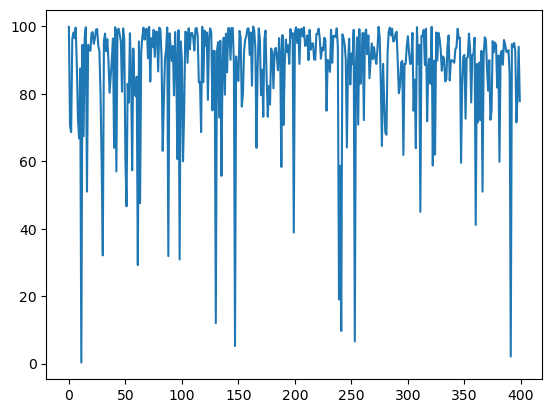

Number of accuracies above 95%: 148


In [29]:
#plt.plot(network.all_train_loss)
#plt.plot(network.all_train_accuracy)
#plt.plot(network2.test_eval_loss)
plt.plot(network3.test_eval_accuracy)
plt.show()
num_above_95 = sum(1 for acc in network3.test_eval_accuracy if acc > 95)
print(f"Number of accuracies above 95%: {num_above_95}")


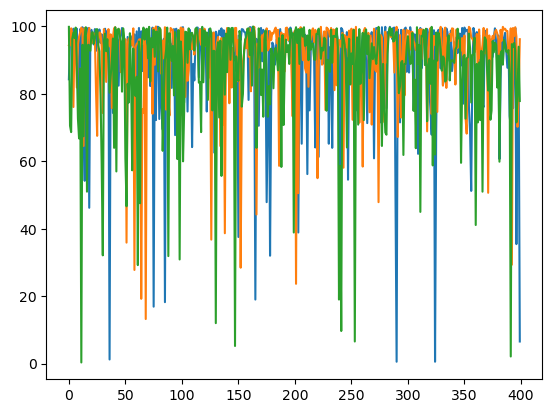

In [30]:
plt.plot(network.test_eval_accuracy)
plt.plot(network2.test_eval_accuracy)
plt.plot(network3.test_eval_accuracy)
#num_above_95 = sum(1 for acc in network2.test_eval_accuracy if acc == 100)
#print(f"Number of accuracies equal 100%: {num_above_95}")
